In [303]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import os
import datetime as dt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from decimal import *

import matplotlib.pyplot as plt 
%matplotlib inline

In [304]:
from numpy.linalg import inv

In [363]:
from cvxpy import *

In [384]:
from IPython.core.debugger import Tracer

In [539]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

In [305]:
root_dir = '/Users/yma/Dropbox/MFE230K_Asset/Dynamic_Factor_Timing_Project'

In [306]:
def align_data(df_assets, df_factors):
    
    # concatenate factors and assets data
    df_all = pd.concat([df_assets, df_factors], axis = 1)
    df_all.dropna(inplace = True)

    N_factors = df_factors.shape[1]
    N_assets = df_assets.shape[1]

    if (N_assets + N_factors) != df_all.shape[1]:
        print('error!')
    
    df_assets = df_all.iloc[:, :N_assets]
    df_factors = df_all.iloc[:, N_assets:]
    
    return df_assets, df_factors

In [586]:
# read factor data
df_factors = pd.read_csv(root_dir + '/data' + \
                        '/No_Liquidity_Monthly_Factors_Log_Returns_Aggregated.csv')

df_factors.set_index('Date', inplace = True)
df_factors.index = pd.to_datetime(df_factors.index)
df_factors.index = df_factors.index.map(lambda x:x.strftime('%Y-%m'))


# read the assets
df_assets  = pd.read_csv(root_dir + '/data/asset_return.csv')
df_assets = df_assets.rename(columns = {df_assets.columns[0]:'Date'})
df_assets.set_index('Date', inplace = True)
df_assets.sort_index(inplace = True)

df_assets, df_factors = align_data(df_assets, df_factors)
df_assets = df_assets.subtract(df_factors['RF'], axis = 0)

In [587]:
# get rid of risk free
df_RF = df_factors['RF']
df_factors = df_factors.drop('RF', axis = 1)

In [588]:
df_factors = df_factors.rename(columns = {'Last_Price (High Yield Credit Spread)':'HY Credit Spread', \
                                         'Credit Spread Investment Grade':'IG Credit Spread'})

In [589]:
# read trading cost
df_cost = pd.read_csv(root_dir + '/data/asset_cost.csv', index_col = 0)

In [590]:
df_factors.head()

,Momentum,BXM Level (Volatility),Mkt-RF,SMB,HML,HY Credit Spread,IG Credit Spread
2000-07,0.52,626.63,1.03,0.77,-0.41,6.64,201.9
2000-08,1.20,661.37,1.19,0.16,-0.66,6.93,229.5
2000-09,-0.87,649.80,-1.26,0.70,1.28,7.06,230.8
2000-10,0.83,645.19,2.75,0.59,-1.66,7.90,235.9
2000-11,1.36,626.49,-2.03,-0.67,1.50,9.11,248.2


# factor

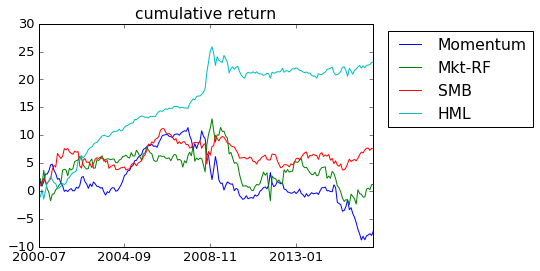

In [591]:
df_factors[['Momentum','Mkt-RF','SMB', 'HML']].cumsum().plot()
plt.legend(bbox_to_anchor=(1.5, 1))
plt.title('cumulative return')

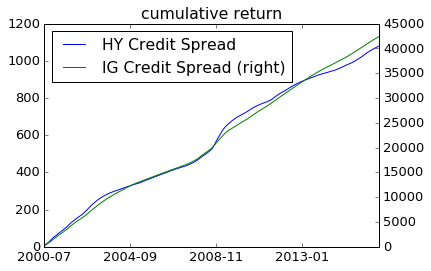

In [592]:
df_factors[ ['HY Credit Spread','IG Credit Spread'] ].cumsum().plot(secondary_y = 'IG Credit Spread')
plt.title('cumulative return')

In [593]:
# do regression
def factor_decomposition(df_assets, df_factors):
    df_pvalues = pd.DataFrame(index = df_factors.columns, columns = df_assets.columns)
    #df_betas =  pd.DataFrame(index = df_factors.columns, columns = df_assets.columns)
    df_betas = pd.DataFrame(columns = df_assets.columns)
    
    for asset in df_assets.columns:
        Y = df_assets[asset]
        X = df_factors
        X = sm.add_constant(X)

        model = sm.OLS(Y, X)
        results = model.fit()

        df_betas[asset] = results.params
        df_pvalues[asset] = results.pvalues
        df_pvalues.loc['R2(%)', asset] = results.rsquared * 100
    
    return df_betas.iloc[1:,:], df_betas.iloc[0,:], df_pvalues

In [584]:
df_betas, df_const, df_pvalues = factor_decomposition(df_assets, df_factors)

In [585]:
df_pvalues

,Equity_russel_3000,Equity_global_MSCI_ACWI,Bond_US_Barclay_ETF,Bond_US_Barclay_TIPS,Bond_US_HighYield_bond_Index,IYR,FOF_Fund of Fund,PE
Momentum,0.028906,0.034022,0.345667,0.949580,0.164802,0.004777,0.979520,0.339854
BXM Level (Volatility),0.862481,0.746716,0.022531,0.702751,0.675092,0.185009,0.760181,0.103069
Mkt-RF,0.702312,0.367161,0.984851,0.857636,0.020402,0.958280,0.002716,0.285619
SMB,0.241920,0.206173,0.162833,0.138055,0.113418,0.243110,0.262175,0.970147
HML,0.004932,0.008349,0.238702,0.143805,0.000066,0.058945,0.000566,0.304146
HY Credit Spread,0.000220,0.001778,0.176387,0.138771,0.002632,0.002998,0.000003,0.300482
IG Credit Spread,0.016343,0.097847,0.000094,0.004977,0.001566,0.146401,0.000186,0.762069
R2(%),16.292474,14.205137,18.267590,7.266467,17.260851,11.353962,26.454359,9.260433


In [551]:
def mean_variance_model(asset_alpha, asset_cov, lam = 10000):
    N_asset = asset_cov.shape[0]
    w = Variable(N_asset)
    gamma = Parameter(sign = 'positive')
    ret = np.array(asset_alpha).T * w
    risk = quad_form(w, np.array(asset_cov))
    prob = Problem(Maximize(ret - gamma * risk), [sum_entries(w) == 1, w >= 0])
    gamma.value = lam
    prob.solve()
    
    df_sol = pd.Series(data = np.array(w.value).flatten(), index = asset_alpha.index)
    return df_sol

In [594]:
def mean_variance_model_TC(asset_alpha, asset_cov, df_cost, w0, lam = 10000):
    N_asset = asset_cov.shape[0]
    w = Variable(N_asset)
    gamma = Parameter(sign = 'positive')
    ret = np.array(asset_alpha).T * w
    risk = quad_form(w, np.array(asset_cov))
    trading_cost = np.array(df_cost.loc['trading',:])*abs(w - np.array(w0))
    holding_cost = np.array(df_cost.loc['holding',:])*w / 12
    
    prob = Problem(Maximize(ret - gamma * risk - trading_cost - holding_cost),\
                   [sum_entries(w) == 1, w >= 0])
                   
    gamma.value = lam
    prob.solve()
    
    df_sol = pd.Series(data = np.array(w.value).flatten(), index = asset_alpha.index)
    return df_sol

In [595]:
def portfolio(df_assets, df_weight, df_cost, df_RF):
    '''
    asset return for each period, and weights
    '''
    # transaction cost for each month
    # first line should be cash holding
    
    pf_value = pd.Series(index = df_weight.index)
    pf_value.iloc[0] = 1

    for i in np.arange(1, df_weight.shape[0]):
        month = df_assets.index[i]
      
        trading_cost = np.abs(df_weight.iloc[i,:] - df_weight.iloc[i-1,:]).dot(\
                                df_cost.loc['trading', :]) * pf_value.iloc[i-1]
        
        pf_value.iloc[i] = pf_value.iloc[i-1] * \
            df_weight.iloc[i,:].dot(1 + df_assets.loc[month,:] + df_RF.loc[month]\
                                    - df_cost.loc['holding',:]/12) - \
            trading_cost
    
    return pf_value

# Benchmark, asset pred

In [608]:
# covariance prediction
alpha_ = 0.5
#alpha_ = 0.0

df_weight = pd.DataFrame(data = np.zeros( df_assets.shape ), index = df_assets.index, columns = df_assets.columns)
N_skip = 24

for month in df_assets.index:
    
    ind = np.where(df_assets.index == month)[0][0]
    if ind < N_skip:
        continue

    # prediction on current month
    # use previous data
    df_prev_factor = df_factors.iloc[:ind,:]
    df_prev_asset = df_assets.iloc[:ind, :]
    
    n = df_prev_factor.shape[0]
    weights = (1 - alpha_) * alpha_** (n - np.arange(1, n+1))
    weights = weights / np.sum(weights)
    
    df_prev_factor = df_prev_factor.multiply(weights, axis = 0)
    df_prev_asset = df_prev_asset.multiply(weights, axis = 0)
    
    # prediction of factor alpha
    factor_alpha = df_prev_factor.mean()
    
    # covariance matrix of factors
    factor_cov = df_prev_factor.cov()
    
    # beta
    betas, consts, pvalues = factor_decomposition(df_prev_asset, df_prev_factor)
    
    # covariance between assets
    #asset_alpha = betas.transpose().dot(factor_alpha) + consts
    #asset_cov = betas.transpose().dot(factor_cov).dot(betas)
    asset_alpha = df_prev_asset.mean()
    asset_cov = df_prev_asset.cov()
    
    # optimization models
    #df_weight.loc[month,:] = 1/df_weight.shape[1]
    df_weight.loc[month, : ] = mean_variance_model_TC(asset_alpha, asset_cov, df_cost, \
                                                      df_weight.iloc[ind,:], 500)
    
df_weight = df_weight.iloc[N_skip-1:, :]   
df_weight.iloc[0, :] = 0
pf_ref = portfolio(df_assets.astype(float), df_weight.astype(float), df_cost, df_RF)

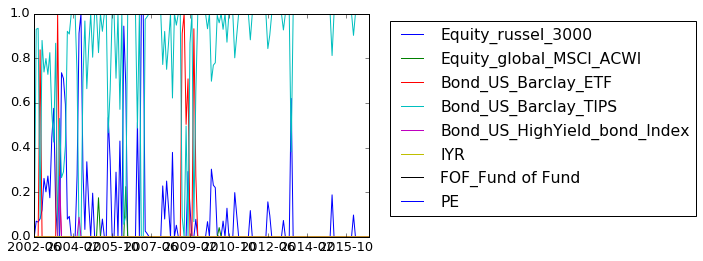

In [609]:
plt.figure(figsize = (10, 4))
df_weight.plot()
plt.legend(bbox_to_anchor=(2, 1))

In [605]:
df_weight

,Equity_russel_3000,Equity_global_MSCI_ACWI,Bond_US_Barclay_ETF,Bond_US_Barclay_TIPS,Bond_US_HighYield_bond_Index,IYR,FOF_Fund of Fund,PE
2002-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2002-07,5.256030e-02,7.268928e-09,4.901929e-09,0.947440,2.325323e-09,2.369432e-09,7.063980e-10,6.066770e-10
2002-08,4.073863e-02,2.118434e-09,1.258362e-09,0.959261,5.989949e-10,5.172867e-10,1.996688e-10,1.691338e-10
2002-09,3.905837e-02,7.067064e-09,3.962280e-09,0.960942,1.813783e-09,1.609002e-09,5.870574e-10,5.049968e-10
2002-10,4.790483e-02,4.592235e-09,1.910686e-09,0.952095,8.952185e-10,7.615567e-10,3.029174e-10,2.646756e-10
2002-11,1.210791e-01,2.579747e-09,1.552829e-09,0.878921,5.539934e-10,4.132612e-10,2.209183e-10,1.731717e-10
2002-12,1.170354e-01,1.552378e-09,8.803776e-10,0.882965,3.267224e-10,2.619505e-10,1.202822e-10,1.009169e-10
2003-01,1.293658e-01,3.532138e-09,2.279981e-09,0.870634,8.369752e-10,6.457790e-10,3.312693e-10,2.754992e-10
2003-02,1.140734e-01,5.452292e-10,2.881300e-10,0.885927,1.191689e-10,8.897810e-11,4.177675e-11,3.555456e-11
2003-03,4.163774e-11,2.792021e-11,4.771748e-11,1.000000,4.600124e-11,4.386190e-11,3.821867e-11,3.499841e-11


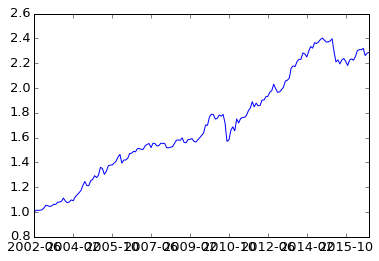

In [602]:
pf_ref.plot()

# factor, exponentially weight

In [610]:
# covariance prediction
alpha_ = 0.5
#alpha_ = 0.0

df_weight = pd.DataFrame(data = np.zeros( df_assets.shape ), index = df_assets.index, columns = df_assets.columns)
N_skip = 24

for month in df_assets.index:
    
    ind = np.where(df_assets.index == month)[0][0]
    if ind < N_skip:
        continue

    # prediction on current month
    # use previous data
    df_prev_factor = df_factors.iloc[:ind,:]
    df_prev_asset = df_assets.iloc[:ind, :]
    
    n = df_prev_factor.shape[0]
    weights = (1 - alpha_) * alpha_** (n - np.arange(1, n+1))
    weights = weights / np.sum(weights)
    
    df_prev_factor = df_prev_factor.multiply(weights, axis = 0)
    df_prev_asset = df_prev_asset.multiply(weights, axis = 0)
    
    # prediction of factor alpha
    factor_alpha = df_prev_factor.mean()
    
    # covariance matrix of factors
    factor_cov = df_prev_factor.cov()
    
    # beta
    betas, consts, pvalues = factor_decomposition(df_prev_asset, df_prev_factor)
    
    # covariance between assets
    asset_alpha = betas.transpose().dot(factor_alpha) + consts
    asset_cov = betas.transpose().dot(factor_cov).dot(betas)
    #asset_alpha = df_prev_asset.mean()
    #asset_cov = df_prev_asset.cov()
    
    # optimization models
    #df_weight.loc[month,:] = 1/df_weight.shape[1]
    df_weight.loc[month, : ] = mean_variance_model_TC(asset_alpha, asset_cov, df_cost, \
                                                      df_weight.iloc[ind,:], 5000)
    
df_weight = df_weight.iloc[N_skip-1:, :]   
df_weight.iloc[0, :] = 0

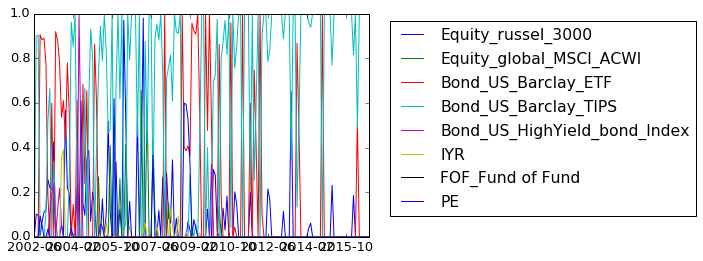

In [611]:
plt.figure(figsize = (10, 4))
df_weight.plot()
plt.legend(bbox_to_anchor=(2, 1))

In [612]:
pf = portfolio(df_assets.astype(float), df_weight.astype(float), df_cost, df_RF)

In [613]:
pf1 = pf.copy()

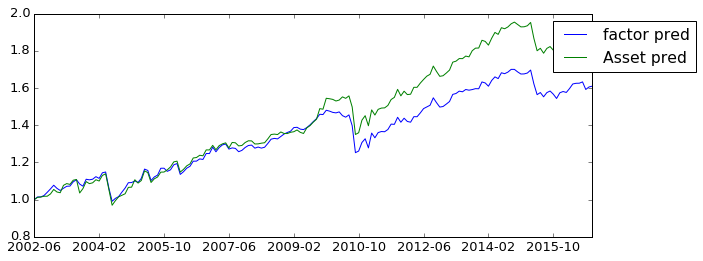

In [614]:
plt.figure(figsize = (10, 4))
pf.plot(label = 'factor pred')
pf_ref.plot(label = 'Asset pred')
plt.legend(bbox_to_anchor=(1.2, 1))

In [561]:
betas

,Equity_russel_3000,Equity_global_MSCI_ACWI,Bond_US_Barclay_ETF,Bond_US_Barclay_TIPS,Bond_US_HighYield_bond_Index,IYR,FOF_Fund of Fund,PE
Momentum,-0.048189,-0.042651,0.006785,0.004793,0.007146,-0.023999,-0.001888,0.003571
BXM Level (Volatility),-0.000204,-0.000352,0.000136,0.000056,0.000356,0.000149,0.000108,-0.000576
Mkt-RF,-0.045006,-0.051736,0.008117,0.002063,0.007885,0.006233,0.001601,-0.183841
SMB,-0.053944,-0.052648,0.004482,-0.001482,-0.003388,0.010923,-0.003957,-0.009943
HML,-0.099678,-0.103060,0.015338,0.003348,0.022660,0.028235,0.000336,-0.227253
HY Credit Spread,0.000024,0.009772,0.001379,-0.003060,-0.020931,0.012879,-0.003365,0.097040
IG Credit Spread,0.000094,0.000126,-0.000259,0.000025,-0.000010,-0.000638,-0.000086,-0.003265


# factor, choose value + momentum

In [580]:
# covariance prediction

df_weight = pd.DataFrame(data = np.zeros( df_assets.shape ), index = df_assets.index, columns = df_assets.columns)
N_skip = 12

for month in df_assets.index:
    
    ind = np.where(df_assets.index == month)[0][0]
    if ind < N_skip:
        continue

    # prediction on current month
    # use previous data
    df_prev_factor = df_factors.iloc[:ind,:]
    df_prev_asset = df_assets.iloc[:ind, :]
    
    n = df_prev_factor.shape[0]
    weights = (1 - alpha_) * alpha_** (n - np.arange(1, n+1))
    weights = weights / np.sum(weights)
    
    df_prev_factor = df_prev_factor.multiply(weights, axis = 0)
    df_prev_asset = df_prev_asset.multiply(weights, axis = 0)
    
    # prediction of factor alpha
    factor_alpha = df_prev_factor.mean()
    
    # covariance matrix of factors
    factor_cov = df_prev_factor.cov()
    
    # beta
    df_prev_factor['Momentum+HML'] = 0.5* (df_prev_factor['Momentum'] + df_prev_factor['HML'])
    del df_prev_factor['Momentum']
    del df_prev_factor['HML']
    
    betas, consts, pvalues = factor_decomposition(df_prev_asset, df_prev_factor)
    
    if (factor_alpha.loc['Momentum'] + factor_alpha.loc['HML']) > 0:
        ind_max = np.argmax(betas.loc['Momentum+HML',:])
        if betas.loc['Momentum+HML',ind_max] > 0:
            df_weight.loc[month, ind_max] = 1
    elif (factor_alpha.loc['Momentum'] + factor_alpha.loc['HML']) < 0:
        ind_max = np.argmax( -betas.loc['Momentum+HML',:])
        if betas.loc['Momentum+HML',ind_max] < 0:
            df_weight.loc[month, ind_max] = 1   
    else:
        df_weight.iloc[ind, :] = df_weight.iloc[ind-1,:]

    # covariance between assets
    #asset_alpha = betas.transpose().dot(factor_alpha) + consts
    #asset_cov = betas.transpose().dot(factor_cov).dot(betas)
    #asset_alpha = df_prev_asset.mean()
    #asset_cov = df_prev_asset.cov()
    
    # optimization models
    #df_weight.loc[month,:] = 1/df_weight.shape[1]
    #df_weight.loc[month, : ] = mean_variance_model(asset_alpha, asset_cov, 10000)

df_weight = df_weight.iloc[N_skip-1:, :]   
df_weight.iloc[0, :] = 0

In [581]:
pf = portfolio(df_assets.astype(float), df_weight.astype(float), df_cost, df_RF)

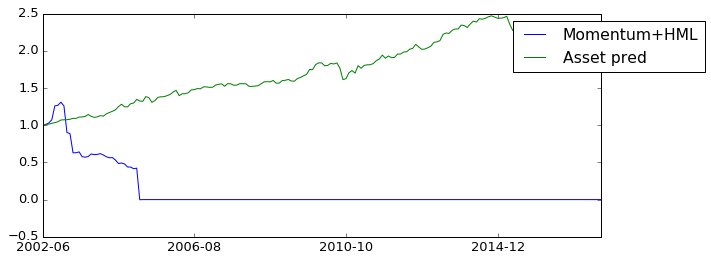

In [582]:
plt.figure(figsize = (10, 4))
pf.plot(label = 'Momentum+HML')
pf_ref.plot(label = 'Asset pred')
plt.legend(bbox_to_anchor=(1.2, 1))

In [497]:
df_weight.tail()

,Equity_russel_3000,Equity_global_MSCI_ACWI,Bond_US_Barclay_ETF,Bond_US_Barclay_TIPS,Bond_US_HighYield_bond_Index,IYR,FOF_Fund of Fund,PE
2016-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
